# DPO Loss Function

**Deep dive into the mathematics**

## The DPO Loss

$$\mathcal{L}_{\text{DPO}} = -\mathbb{E} \left[ \log \sigma \left( \beta \left( \log \frac{\pi_\theta(y_w|x)}{\pi_{\text{ref}}(y_w|x)} - \log \frac{\pi_\theta(y_l|x)}{\pi_{\text{ref}}(y_l|x)} \right) \right) \right]$$

Let's break this down step by step.

## Step 1: Log Ratios

For each response, compute the log ratio between policy and reference:

$$\text{logratio}_w = \log \pi_\theta(y_w|x) - \log \pi_{\text{ref}}(y_w|x)$$
$$\text{logratio}_l = \log \pi_\theta(y_l|x) - \log \pi_{\text{ref}}(y_l|x)$$

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def compute_log_ratios(
    policy_logps: torch.Tensor,
    reference_logps: torch.Tensor
) -> torch.Tensor:
    """
    Compute log(π_θ / π_ref) = log π_θ - log π_ref
    """
    return policy_logps - reference_logps

# Example
policy_chosen_logps = torch.tensor([-45.0, -50.0, -48.0, -52.0])
policy_rejected_logps = torch.tensor([-48.0, -52.0, -46.0, -55.0])
ref_chosen_logps = torch.tensor([-46.0, -51.0, -49.0, -53.0])
ref_rejected_logps = torch.tensor([-47.0, -51.0, -47.0, -54.0])

chosen_logratios = compute_log_ratios(policy_chosen_logps, ref_chosen_logps)
rejected_logratios = compute_log_ratios(policy_rejected_logps, ref_rejected_logps)

print(f"Chosen log ratios: {chosen_logratios.tolist()}")
print(f"Rejected log ratios: {rejected_logratios.tolist()}")

Chosen log ratios: [1.0, 1.0, 1.0, 1.0]
Rejected log ratios: [-1.0, -1.0, 1.0, -1.0]


## Step 2: Logits

The "logits" for the preference prediction:

$$\text{logits} = \beta \cdot (\text{logratio}_w - \text{logratio}_l)$$

This represents how much more the policy prefers the chosen response relative to reference.

In [2]:
beta = 0.1

logits = beta * (chosen_logratios - rejected_logratios)
print(f"Logits (β={beta}): {logits.tolist()}")

# Positive logits → policy prefers chosen (correct!)
# Negative logits → policy prefers rejected (wrong!)
print(f"Policy prefers chosen: {(logits > 0).tolist()}")

Logits (β=0.1): [0.20000000298023224, 0.20000000298023224, 0.0, 0.20000000298023224]
Policy prefers chosen: [True, True, False, True]


## Step 3: Loss

$$\mathcal{L} = -\log \sigma(\text{logits})$$

This is binary cross-entropy loss where:
- High logits → low loss (correct preference)
- Low logits → high loss (wrong preference)

In [3]:
# Complete DPO loss
def compute_dpo_loss_detailed(
    policy_chosen_logps: torch.Tensor,
    policy_rejected_logps: torch.Tensor,
    ref_chosen_logps: torch.Tensor,
    ref_rejected_logps: torch.Tensor,
    beta: float = 0.1
) -> dict:
    """Compute DPO loss with detailed metrics."""
    
    # Step 1: Log ratios
    chosen_logratios = policy_chosen_logps - ref_chosen_logps
    rejected_logratios = policy_rejected_logps - ref_rejected_logps
    
    # Step 2: Logits
    logits = beta * (chosen_logratios - rejected_logratios)
    
    # Step 3: Loss
    loss = -F.logsigmoid(logits).mean()
    
    # Metrics
    accuracy = (logits > 0).float().mean()
    margin = (chosen_logratios - rejected_logratios).mean()
    
    return {
        'loss': loss,
        'accuracy': accuracy,
        'margin': margin,
        'chosen_logratios_mean': chosen_logratios.mean(),
        'rejected_logratios_mean': rejected_logratios.mean()
    }

metrics = compute_dpo_loss_detailed(
    policy_chosen_logps, policy_rejected_logps,
    ref_chosen_logps, ref_rejected_logps,
    beta=0.1
)

print("DPO Loss Metrics:")
for k, v in metrics.items():
    print(f"  {k}: {v.item():.4f}")

DPO Loss Metrics:
  loss: 0.6219
  accuracy: 0.7500
  margin: 1.5000
  chosen_logratios_mean: 1.0000
  rejected_logratios_mean: -0.5000


## The β Parameter

β controls how much the policy can deviate from reference:

| β Value | Effect |
|---------|--------|
| **Low (0.01)** | Policy stays close to reference |
| **Medium (0.1)** | Balanced (typical) |
| **High (1.0)** | Policy can deviate more |

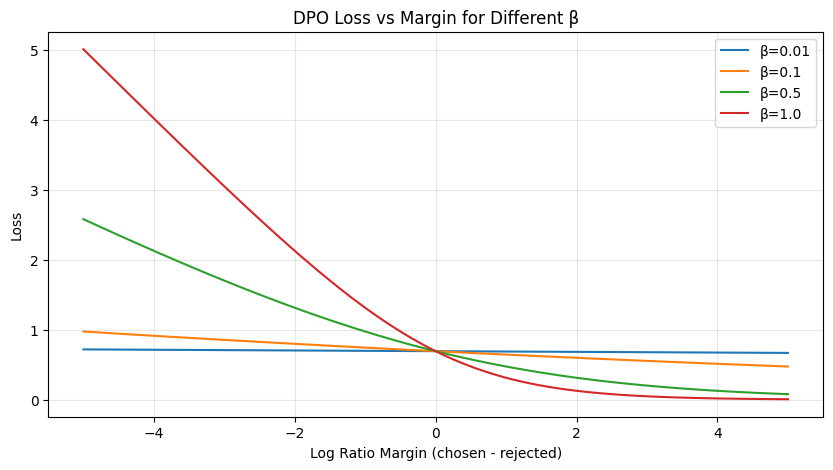

Higher β → Steeper loss curve → Stronger preference signal


In [4]:
# Visualize effect of β
margin_range = np.linspace(-5, 5, 100)

plt.figure(figsize=(10, 5))
for beta in [0.01, 0.1, 0.5, 1.0]:
    logits = beta * margin_range
    loss = -np.log(1 / (1 + np.exp(-logits)))  # -log sigmoid
    plt.plot(margin_range, loss, label=f'β={beta}')

plt.xlabel('Log Ratio Margin (chosen - rejected)')
plt.ylabel('Loss')
plt.title('DPO Loss vs Margin for Different β')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Higher β → Steeper loss curve → Stronger preference signal")

## Label Smoothing

Optional: Add label smoothing for regularization:

$$\mathcal{L}_{\text{smooth}} = (1-\epsilon) \cdot \mathcal{L}_{\text{chosen}} + \epsilon \cdot \mathcal{L}_{\text{rejected}}$$

In [5]:
def compute_dpo_loss_with_smoothing(
    policy_chosen_logps: torch.Tensor,
    policy_rejected_logps: torch.Tensor,
    ref_chosen_logps: torch.Tensor,
    ref_rejected_logps: torch.Tensor,
    beta: float = 0.1,
    label_smoothing: float = 0.0
) -> torch.Tensor:
    """DPO loss with optional label smoothing."""
    
    chosen_logratios = policy_chosen_logps - ref_chosen_logps
    rejected_logratios = policy_rejected_logps - ref_rejected_logps
    
    logits = beta * (chosen_logratios - rejected_logratios)
    
    if label_smoothing > 0:
        # Soft targets
        loss_chosen = -F.logsigmoid(logits)
        loss_rejected = -F.logsigmoid(-logits)
        loss = (1 - label_smoothing) * loss_chosen + label_smoothing * loss_rejected
    else:
        loss = -F.logsigmoid(logits)
    
    return loss.mean()

# Compare with and without smoothing
loss_no_smooth = compute_dpo_loss_with_smoothing(
    policy_chosen_logps, policy_rejected_logps,
    ref_chosen_logps, ref_rejected_logps,
    beta=0.1, label_smoothing=0.0
)

loss_smooth = compute_dpo_loss_with_smoothing(
    policy_chosen_logps, policy_rejected_logps,
    ref_chosen_logps, ref_rejected_logps,
    beta=0.1, label_smoothing=0.1
)

print(f"Loss without smoothing: {loss_no_smooth.item():.4f}")
print(f"Loss with smoothing (ε=0.1): {loss_smooth.item():.4f}")

Loss without smoothing: 0.6219
Loss with smoothing (ε=0.1): 0.6369


## Next Steps

Now let's implement the complete DPO training loop.